In [1]:
!pip install wordcloud

In [2]:
!pip install tensorflow

In [3]:
!pip install shap

In [4]:
!pip install xgboost


In [5]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from wordcloud import WordCloud

In [6]:
# Upload and load the dataset (you can replace this with any file path)
file_path = "Downloads\\phishing\\CEAS-08.csv" # Provide your dataset path here
df = pd.read_csv(file_path, low_memory=False)
# df = df.sample(n=25000, random_state=42)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


In [8]:
df.dropna()
df['subject'] = df['subject'].fillna('')
df['body'] = df['body'].fillna('')
# Remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers from numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    original_count = len(df)
    df = remove_outliers_iqr(df, col)
    print(f"Removed outliers from {col}: {original_count - len(df)} rows removed.")

# Capping extreme values (5% and 95% percentiles)
def cap_extreme_values(dataframe):
    for col in dataframe.select_dtypes(include=[np.number]).columns:
        lower_limit = dataframe[col].quantile(0.05)
        upper_limit = dataframe[col].quantile(0.95)
        dataframe[col] = np.clip(dataframe[col], lower_limit, upper_limit)
    return dataframe

df = cap_extreme_values(df)

Removed outliers from label: 0 rows removed.
Removed outliers from urls: 0 rows removed.


In [9]:
import re

# Updated Text Cleaning Function
def clean_text_and_extract_features(text):
    if not isinstance(text, str):
        return '', 0, 0  # Default values for NaN or invalid text
    
    # Remove URLs and count the number of URLs
    url_pattern = r'http[s]?://\S+'
    urls = re.findall(url_pattern, text)
    num_urls = len(urls)
    text = re.sub(url_pattern, '', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Convert to lowercase
    text = text.lower()
    
    # Calculate body length (number of characters)
    body_length = len(text)
    
    return text, num_urls, body_length

# Apply the updated function to the 'body' column
df[['cleaned_body', 'num_urls', 'body_length']] = df['body'].apply(
    lambda x: pd.Series(clean_text_and_extract_features(x))
)

# Verify the updated dataset
print(df.head())
print("Columns in the updated dataset:", df.columns)



                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2008 19:31:21 -0400   

                                             subject  \
0                          Never agree to be a loser   
1  

In [10]:
print(df.columns)


Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'cleaned_body', 'num_urls', 'body_length'],
      dtype='object')


In [11]:
def extract_features(df):
    # Number of URLs in the email body
    df['num_urls'] = df['cleaned_body'].apply(lambda x: len(re.findall(r'http[s]?://\S+', x)))
    # Subject Length - Comment out this line if the subject column does not exist
    # df['subject_length'] = df['subject'].apply(len)
    # Body Length
    df['body_length'] = df['cleaned_body'].apply(len)
    # Check for phishing keywords (e.g., "prince", "lottery")
    df['has_phishing_keywords'] = df['cleaned_body'].apply(
        lambda x: int(bool(re.search(r'(prince|lottery|winner|urgent|free|click)', x, re.IGNORECASE)))
    )
    return df

    df = extract_features(df)



In [12]:
# Save the modified DataFrame to a new CSV file
df.to_csv("phishing_new_emails.csv", index=False)

print("Dataset saved to 'phishing_new_emails.csv'")

Dataset saved to 'phishing_new_emails.csv'


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sender        39154 non-null  object
 1   receiver      38692 non-null  object
 2   date          39154 non-null  object
 3   subject       39154 non-null  object
 4   body          39154 non-null  object
 5   label         39154 non-null  int64 
 6   urls          39154 non-null  int64 
 7   cleaned_body  39154 non-null  object
 8   num_urls      39154 non-null  int64 
 9   body_length   39154 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 3.0+ MB


In [14]:
import pandas as pd
import joblib
import os  # To create the save_model directory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack, csr_matrix
from collections import Counter

# Ensure the save_model directory exists
os.makedirs('save_model', exist_ok=True)

# Load your data (assuming df is already loaded)
# Uncomment the following line if reading from a CSV file:
# df = pd.read_csv('your_data.csv')

# Assume df contains 'cleaned_body', 'num_urls', and 'body_length' columns
X = df[['cleaned_body', 'num_urls', 'body_length']]  # Features: text + numeric
y = df['label']  # Labels (phishing or not)

# Step 1: Filter rare classes (classes with fewer than 2 samples)
y_counts = y.value_counts()
rare_classes = y_counts[y_counts < 2].index  # Identify rare classes
X_filtered = X[~y.isin(rare_classes)]  # Remove corresponding rows in X
y_filtered = y[~y.isin(rare_classes)]  # Remove rare classes from y

# Display class distribution after filtering
print("Class distribution after filtering rare classes:", Counter(y_filtered))

# Step 2: TF-IDF Vectorizer for text feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=1002)
try:
    X_tfidf = tfidf_vectorizer.fit_transform(X_filtered['cleaned_body'])
    # Save the TF-IDF Vectorizer for future use
    joblib.dump(tfidf_vectorizer, 'save_model/tfidf_vectorizer.joblib')
    print("TF-IDF vectorizer saved successfully.")
except Exception as e:
    print("Error during TF-IDF vectorization:", e)
    raise

# Step 3: Combine sparse (text features) and dense (other features) data
additional_features = X_filtered.drop(columns=['cleaned_body']).values  # Extract numeric features
additional_features_sparse = csr_matrix(additional_features)  # Convert to sparse matrix
X_combined = hstack([X_tfidf, additional_features_sparse])  # Combine features

# Step 4: Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)

# Step 5: Handle class imbalance in the training set using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print("Class distribution after RandomUnderSampling:", Counter(y_train_resampled))

# Initialize models to test
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    # "SVM": SVC(class_weight='balanced', random_state=42, probability=True),  # Enable probability for SVM
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    try:
        # Train the model
        model.fit(X_train_resampled, y_train_resampled)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Test Set Accuracy: {accuracy:.4f}")
        print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))

        # Save the trained model
        model_filename = f'save_model/{model_name.replace(" ", "_").lower()}_model.joblib'
        joblib.dump(model, model_filename)
        print(f"{model_name} model saved to {model_filename}.")
    except Exception as e:
        print(f"Error training {model_name}:", e)

print("\nAll models trained and saved successfully.")



Class distribution after filtering rare classes: Counter({1: 21842, 0: 17312})
TF-IDF vectorizer saved successfully.
Class distribution after RandomUnderSampling: Counter({0: 12984, 1: 12984})

Training Random Forest...
Random Forest Test Set Accuracy: 0.9900
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4328
           1       0.99      0.99      0.99      5461

    accuracy                           0.99      9789
   macro avg       0.99      0.99      0.99      9789
weighted avg       0.99      0.99      0.99      9789

Random Forest model saved to save_model/random_forest_model.joblib.

Training Gradient Boosting...
Gradient Boosting Test Set Accuracy: 0.9749
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      4328
           1       0.97      0.98      0.98      5461

    accuracy              

C:\Users\DAR LAPTOPS\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Test Set Accuracy: 0.9754
AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      4328
           1       0.97      0.98      0.98      5461

    accuracy                           0.98      9789
   macro avg       0.98      0.97      0.98      9789
weighted avg       0.98      0.98      0.98      9789

AdaBoost model saved to save_model/adaboost_model.joblib.

Training XGBoost...


C:\Users\DAR LAPTOPS\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Set Accuracy: 0.9903
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4328
           1       0.99      0.99      0.99      5461

    accuracy                           0.99      9789
   macro avg       0.99      0.99      0.99      9789
weighted avg       0.99      0.99      0.99      9789

XGBoost model saved to save_model/xgboost_model.joblib.

All models trained and saved successfully.


In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Create an empty dictionary to store model accuracies
accuracies = {}

# Calculate accuracy for each model
for model_name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Compute accuracy and store it
    accuracies[model_name] = accuracy_score(y_test, y_pred)

# Convert the accuracies dictionary to a DataFrame for a tabular view
accuracy_table = pd.DataFrame(list(accuracies.items()), columns=["Model", "Accuracy"])

# Print the accuracy table
print(accuracy_table)


                 Model  Accuracy
0        Random Forest  0.989989
1    Gradient Boosting  0.974870
2  Logistic Regression  0.984779
3  K-Nearest Neighbors  0.913372
4          Naive Bayes  0.934518
5        Decision Tree  0.978547
6             AdaBoost  0.975381
7              XGBoost  0.990295


Calculating confusion matrix for Random Forest...


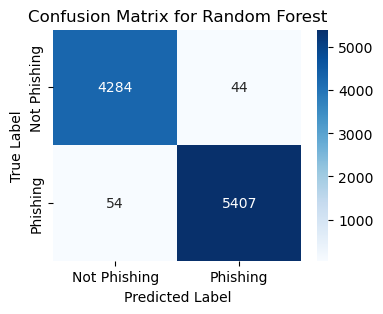

Calculating confusion matrix for Gradient Boosting...


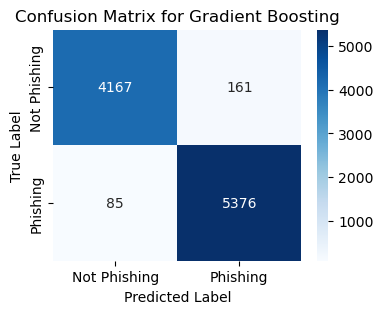

Calculating confusion matrix for Logistic Regression...


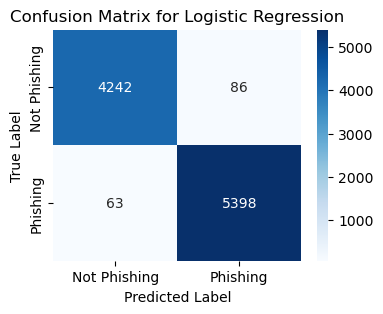

Calculating confusion matrix for K-Nearest Neighbors...


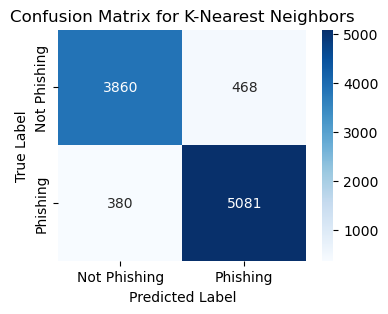

Calculating confusion matrix for Naive Bayes...


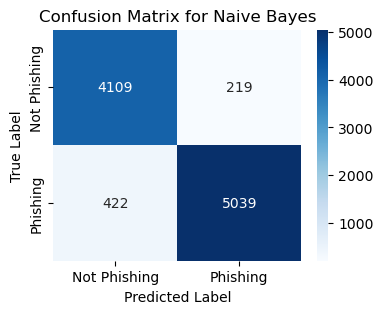

Calculating confusion matrix for Decision Tree...


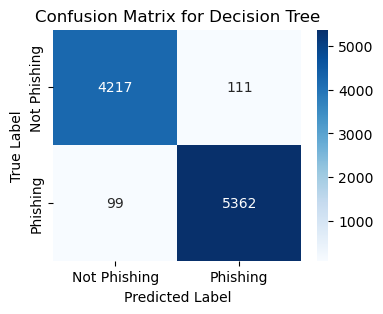

Calculating confusion matrix for AdaBoost...


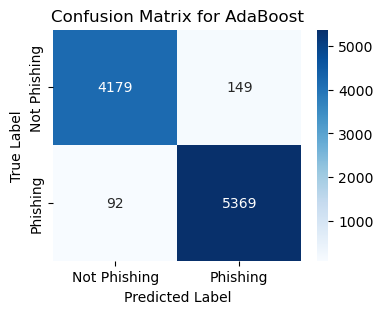

Calculating confusion matrix for XGBoost...


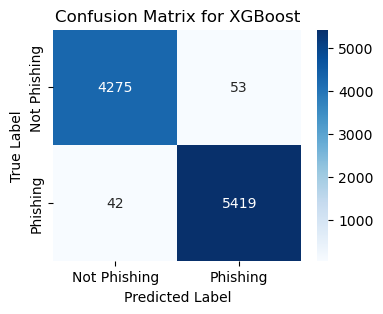

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name, classes):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Calculate and plot confusion matrices for all models
for model_name, model in models.items():
    print(f"Calculating confusion matrix for {model_name}...")
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, model_name, classes=["Not Phishing", "Phishing"])  # Replace with your class labels


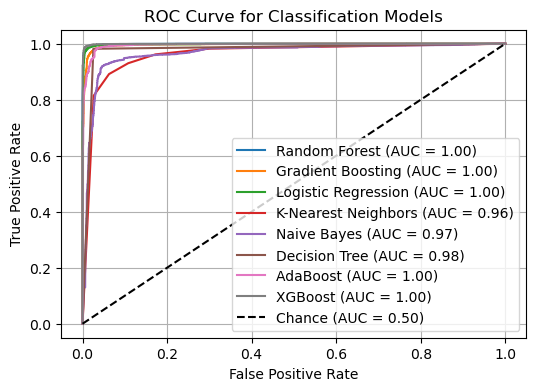

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize a plot
plt.figure(figsize=(6, 4))

# Plot ROC curves for each model
for model_name, model in models.items():
    try:
        # Get prediction probabilities for ROC curve
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]  # Probability for the positive class
        else:
            y_scores = model.decision_function(X_test)  # Use decision function if no predict_proba
        
        # Compute ROC curve and AUC score
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    except Exception as e:
        print(f"Error generating ROC curve for {model_name}: {e}")

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

# Formatting the plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Classification Models")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()
